# Load data

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ReadCSV').getOrCreate()

23/05/21 22:35:24 WARN Utils: Your hostname, YipdeMacBook-Air-3.local resolves to a loopback address: 127.0.0.1; using 192.168.1.106 instead (on interface en0)
23/05/21 22:35:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/21 22:35:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
numPartition = 5
# train_data = sc.textFile('./data/train.csv',numPartition).map(lambda line: line.split(","))
# test_data = sc.textFile('./data/test.csv',numPartition).map(lambda line: line.split(","))
# header = train_data.first()
# train_data = train_data.filter(lambda line: line != header)
# test_data = test_data.filter(lambda line: line != header)

# Please choose which datapath to use
data_path = './data/train.csv'
train_df = spark.read.csv(data_path,header=True,inferSchema=True).repartition(numPartition)

print(train_df)

DataFrame[id: int, clonesize: double, honeybee: double, bumbles: double, andrena: double, osmia: double, MaxOfUpperTRange: double, MinOfUpperTRange: double, AverageOfUpperTRange: double, MaxOfLowerTRange: double, MinOfLowerTRange: double, AverageOfLowerTRange: double, RainingDays: double, AverageRainingDays: double, fruitset: double, fruitmass: double, seeds: double, yield: double]


# Data Preprocess

In [4]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

def vector_to_double(vector):
    return float(vector[0])
udf_v2d = udf(vector_to_double, DoubleType())

input_cols = train_df.columns[1:-1]
output_col = train_df.columns[-1]

feat_assembler = VectorAssembler(inputCols=input_cols,outputCol="features")
yield_assembler = VectorAssembler(inputCols=[output_col],outputCol="yield_vec")
feature_scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",withStd=True, withMean=False)
yield_scaler = StandardScaler(inputCol="yield_vec", outputCol="scaledYield_vec",withStd=True, withMean=False)
yield_normalizer = MinMaxScaler(inputCol="yield_vec", outputCol="scaledYield_vec")

train_data = feat_assembler.transform(train_df).select("features",output_col)
train_data = yield_assembler.transform(train_data).select(['features','yield_vec'])

train_data = feature_scaler.fit(train_data).transform(train_data)
mlp_train_data = yield_normalizer.fit(train_data).transform(train_data)
train_data = yield_scaler.fit(train_data).transform(train_data)
train_data = train_data.withColumn('scaledYield',udf_v2d("scaledYield_vec")).select(['scaledFeatures','scaledYield'])
mlp_train_data = mlp_train_data.withColumn('scaledYield',udf_v2d("scaledYield_vec")).select(['scaledFeatures','scaledYield'])

(train_data, val_data) = train_data.randomSplit([0.8,0.2])
(mlp_train_data, mlp_val_data) = mlp_train_data.randomSplit([0.8,0.2])


23/05/21 22:35:32 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


# Simple Linear Regression

In [5]:
lr = LinearRegression(featuresCol = "scaledFeatures", labelCol = "scaledYield",maxIter=1000,regParam=0.01,elasticNetParam=0.8)

lr_model = lr.fit(train_data)
lr_train_result = lr_model.transform(train_data)
lr_train_result.select("prediction", "scaledYield", "scaledFeatures").show(5)
evaluator = RegressionEvaluator(
    labelCol="scaledYield", predictionCol="prediction", metricName="rmse")
lr_rmse = evaluator.evaluate(lr_train_result)
print("Root Mean Squared Error (RMSE) on train data = %g" % lr_rmse)

lr_predictions = lr_model.transform(val_data)
lr_predictions.select("prediction", "scaledYield", "scaledFeatures").show(5)

lr_rmse = evaluator.evaluate(lr_predictions)
print("Root Mean Squared Error (RMSE) on val data = %g" % lr_rmse)

print(lr_model)  # summary only


23/05/21 22:35:39 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/05/21 22:35:39 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


+------------------+------------------+--------------------+
|        prediction|       scaledYield|      scaledFeatures|
+------------------+------------------+--------------------+
| 3.165607516837725| 2.861637678745875|[1.51625174965797...|
|3.3714448432503765| 2.863128490449435|[1.89531468707246...|
| 4.811832250200615|5.2300118286441295|[1.89531468707246...|
| 5.154576027885589| 4.664877227138155|[1.89531468707246...|
|3.1360953811333783|2.2805764171257423|[1.89531468707246...|
+------------------+------------------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on train data = 0.438507
+-----------------+------------------+--------------------+
|       prediction|       scaledYield|      scaledFeatures|
+-----------------+------------------+--------------------+
|4.843070703109362|4.7320411775818005|[1.89531468707246...|
|3.813664185034569| 3.973935948058426|[1.89531468707246...|
|4.335224794794836| 4.427999587979845|[1.89531468707246...|
|4.0455238

Text(0.5, 1.0, 'Linear Regression Train Result')

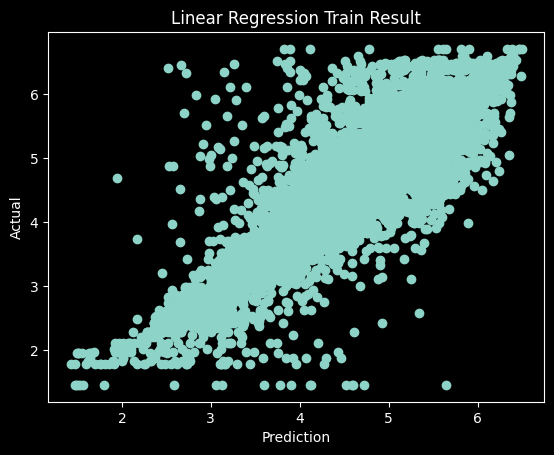

In [6]:
import matplotlib.pyplot as plt
import numpy as np


plt.scatter(np.array(lr_train_result.select('prediction').collect()),np.array(lr_train_result.select('scaledYield').collect()))
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Linear Regression Train Result')

Text(0.5, 1.0, 'Linear Regression Validation Result')

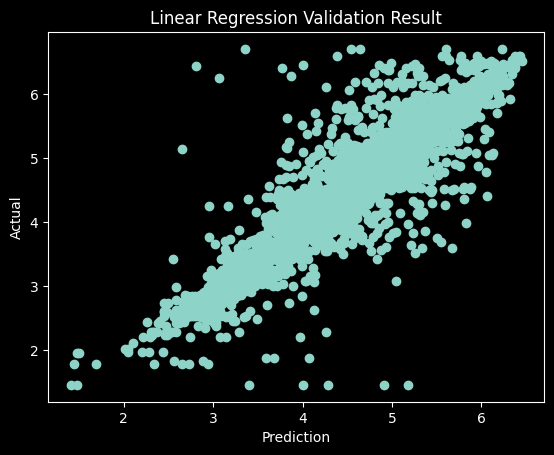

In [7]:
plt.scatter(np.array(lr_predictions.select('prediction').collect()),np.array(lr_predictions.select('scaledYield').collect()))
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Linear Regression Validation Result')

# Random Forest Regressor

In [8]:
rf = RandomForestRegressor(featuresCol = "scaledFeatures", labelCol = "scaledYield",maxDepth=10,numTrees=20)
# print("LogisticRegression parameters:\n" + lr.explainParams() + "\n")
rf_model = rf.fit(train_data)
rf_train_result = rf_model.transform(train_data)
rf_train_result.select("prediction", "scaledYield", "scaledFeatures").show(5)

rf_rmse = evaluator.evaluate(rf_train_result)
print("Root Mean Squared Error (RMSE) on train data = %g" % rf_rmse)

rf_predictions = rf_model.transform(val_data)
rf_predictions.select("prediction", "scaledYield", "scaledFeatures").show(5)

rf_rmse = evaluator.evaluate(rf_predictions)
print("Root Mean Squared Error (RMSE) on val data = %g" % rf_rmse)

print(rf_model)  # summary only

23/05/21 22:35:54 WARN DAGScheduler: Broadcasting large task binary with size 1526.7 KiB
23/05/21 22:35:54 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


+------------------+------------------+--------------------+
|        prediction|       scaledYield|      scaledFeatures|
+------------------+------------------+--------------------+
| 3.019667741953346| 2.861637678745875|[1.51625174965797...|
|2.7884989371193187| 2.863128490449435|[1.89531468707246...|
|  5.04356018624589|5.2300118286441295|[1.89531468707246...|
| 5.061004738117691| 4.664877227138155|[1.89531468707246...|
| 2.749199150893112|2.2805764171257423|[1.89531468707246...|
+------------------+------------------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on train data = 0.35111
+------------------+------------------+--------------------+
|        prediction|       scaledYield|      scaledFeatures|
+------------------+------------------+--------------------+
| 4.996953207568489|4.7320411775818005|[1.89531468707246...|
|3.6249951693584372| 3.973935948058426|[1.89531468707246...|
| 4.371156288585672| 4.427999587979845|[1.89531468707246...|
|4.16

Text(0.5, 1.0, 'Random Forest Regression Train Result')

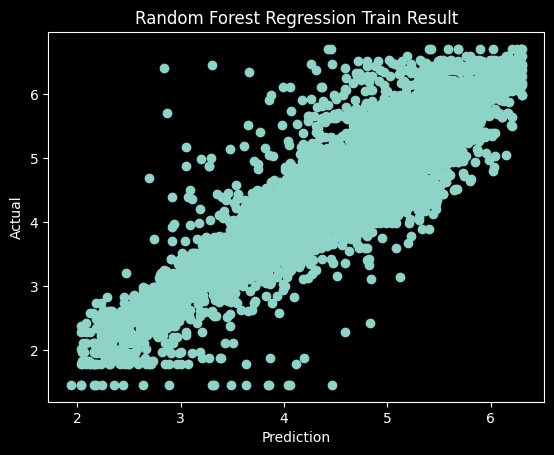

In [9]:
plt.scatter(np.array(rf_train_result.select('prediction').collect()),np.array(rf_train_result.select('scaledYield').collect()))
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Random Forest Regression Train Result')

Text(0.5, 1.0, 'Random Forest Regression Validation Result')

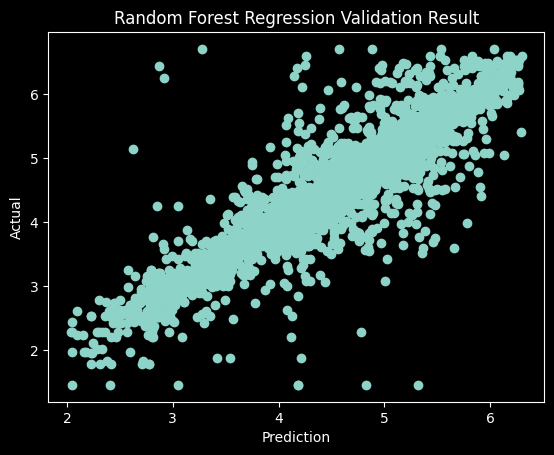

In [10]:
plt.scatter(np.array(rf_predictions.select('prediction').collect()),np.array(rf_predictions.select('scaledYield').collect()))
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Random Forest Regression Validation Result')

In [11]:
data_path = './data/WildBlueberryPollinationSimulationData.csv'
train_df = spark.read.csv(data_path,header=True,inferSchema=True).repartition(numPartition)
print(train_df)

DataFrame[Row#: int, clonesize: double, honeybee: double, bumbles: double, andrena: double, osmia: double, MaxOfUpperTRange: double, MinOfUpperTRange: double, AverageOfUpperTRange: double, MaxOfLowerTRange: double, MinOfLowerTRange: double, AverageOfLowerTRange: double, RainingDays: double, AverageRainingDays: double, fruitset: double, fruitmass: double, seeds: double, yield: double]


In [12]:
input_cols = train_df.columns[1:-1]
output_col = train_df.columns[-1]

feat_assembler = VectorAssembler(inputCols=input_cols,outputCol="features")
yield_assembler = VectorAssembler(inputCols=[output_col],outputCol="yield_vec")
feature_scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",withStd=True, withMean=False)
yield_scaler = StandardScaler(inputCol="yield_vec", outputCol="scaledYield_vec",withStd=True, withMean=False)
yield_normalizer = MinMaxScaler(inputCol="yield_vec", outputCol="scaledYield_vec")

train_data = feat_assembler.transform(train_df).select("features",output_col)
train_data = yield_assembler.transform(train_data).select(['features','yield_vec'])

train_data = feature_scaler.fit(train_data).transform(train_data)
mlp_train_data = yield_normalizer.fit(train_data).transform(train_data)
train_data = yield_scaler.fit(train_data).transform(train_data)
train_data = train_data.withColumn('scaledYield',udf_v2d("scaledYield_vec")).select(['scaledFeatures','scaledYield'])
mlp_train_data = mlp_train_data.withColumn('scaledYield',udf_v2d("scaledYield_vec")).select(['scaledFeatures','scaledYield'])

(train_data, val_data) = train_data.randomSplit([0.8,0.2])
(mlp_train_data, mlp_val_data) = mlp_train_data.randomSplit([0.8,0.2])


In [13]:
lr = LinearRegression(featuresCol = "scaledFeatures", labelCol = "scaledYield",maxIter=1000,regParam=0.01,elasticNetParam=0.8)

lr_model = lr.fit(train_data)
lr_train_result = lr_model.transform(train_data)
lr_train_result.select("prediction", "scaledYield", "scaledFeatures").show(5)
evaluator = RegressionEvaluator(
    labelCol="scaledYield", predictionCol="prediction", metricName="rmse")
lr_rmse = evaluator.evaluate(lr_train_result)
print("Root Mean Squared Error (RMSE) on train data = %g" % lr_rmse)

lr_predictions = lr_model.transform(val_data)
lr_predictions.select("prediction", "scaledYield", "scaledFeatures").show(5)

lr_rmse = evaluator.evaluate(lr_predictions)
print("Root Mean Squared Error (RMSE) on val data = %g" % lr_rmse)

print(lr_model)  # summary only


+-----------------+-----------------+--------------------+
|       prediction|      scaledYield|      scaledFeatures|
+-----------------+-----------------+--------------------+
|4.338503173233672|4.330990068674726|[1.78595339382817...|
|2.156561378922018|2.313585792961856|[1.78595339382817...|
|4.864793140183864|4.847790588607504|[1.78595339382817...|
| 4.79641012841198|4.712076973337733|[1.78595339382817...|
|5.251562747212597|5.174960174832894|[1.78595339382817...|
+-----------------+-----------------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on train data = 0.103841
+-----------------+------------------+--------------------+
|       prediction|       scaledYield|      scaledFeatures|
+-----------------+------------------+--------------------+
|3.497211829409312|3.4525036616701805|[1.78595339382817...|
|4.828152196698902| 4.812230903368912|[1.78595339382817...|
|4.366201501127193| 4.286939442102257|[1.78595339382817...|
|4.975902186524704| 5.008183

Text(0.5, 1.0, 'Linear Regression Train Result')

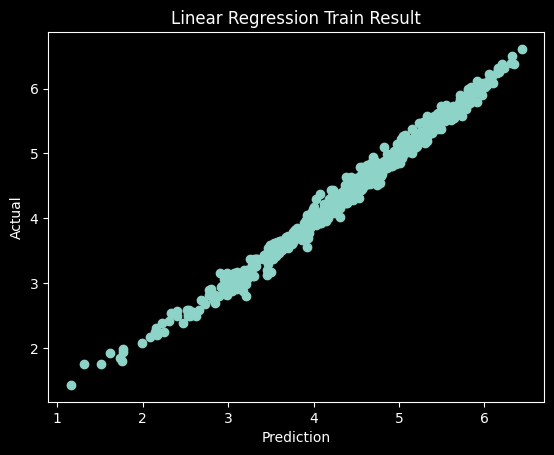

In [14]:
plt.scatter(np.array(lr_train_result.select('prediction').collect()),np.array(lr_train_result.select('scaledYield').collect()))
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Linear Regression Train Result')

Text(0.5, 1.0, 'Linear Regression Validation Result')

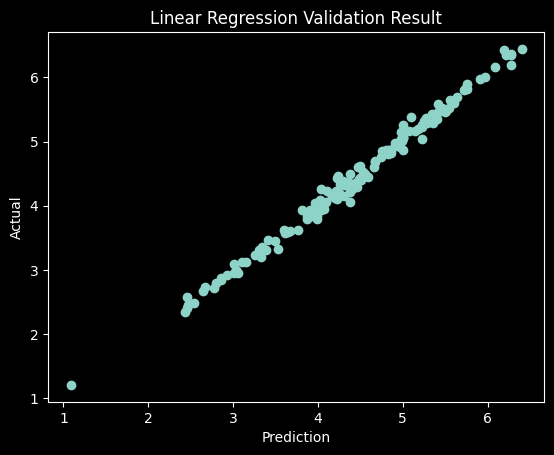

In [15]:
plt.scatter(np.array(lr_predictions.select('prediction').collect()),np.array(lr_predictions.select('scaledYield').collect()))
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Linear Regression Validation Result')

In [16]:
rf = RandomForestRegressor(featuresCol = "scaledFeatures", labelCol = "scaledYield",maxDepth=10,numTrees=20)
# print("LogisticRegression parameters:\n" + lr.explainParams() + "\n")
rf_model = rf.fit(train_data)
rf_train_result = rf_model.transform(train_data)
rf_train_result.select("prediction", "scaledYield", "scaledFeatures").show(5)

rf_rmse = evaluator.evaluate(rf_train_result)
print("Root Mean Squared Error (RMSE) on train data = %g" % rf_rmse)

rf_predictions = rf_model.transform(val_data)
rf_predictions.select("prediction", "scaledYield", "scaledFeatures").show(5)

rf_rmse = evaluator.evaluate(rf_predictions)
print("Root Mean Squared Error (RMSE) on val data = %g" % rf_rmse)

print(rf_model)  # summary only

23/05/21 22:36:09 WARN DAGScheduler: Broadcasting large task binary with size 1098.1 KiB
23/05/21 22:36:09 WARN DAGScheduler: Broadcasting large task binary with size 1451.1 KiB


+-----------------+-----------------+--------------------+
|       prediction|      scaledYield|      scaledFeatures|
+-----------------+-----------------+--------------------+
|  4.4204549503232|4.330990068674726|[1.78595339382817...|
|2.180409053630399|2.313585792961856|[1.78595339382817...|
|4.864620132217949|4.847790588607504|[1.78595339382817...|
|4.856871925939849|4.712076973337733|[1.78595339382817...|
|5.231365428608393|5.174960174832894|[1.78595339382817...|
+-----------------+-----------------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on train data = 0.0593801
+-----------------+------------------+--------------------+
|       prediction|       scaledYield|      scaledFeatures|
+-----------------+------------------+--------------------+
|3.545881587956026|3.4525036616701805|[1.78595339382817...|
|4.820863262849302| 4.812230903368912|[1.78595339382817...|
|4.433547973671242| 4.286939442102257|[1.78595339382817...|
|5.016638239648682| 5.00818

Text(0.5, 1.0, 'Random Forest Regression Train Result')

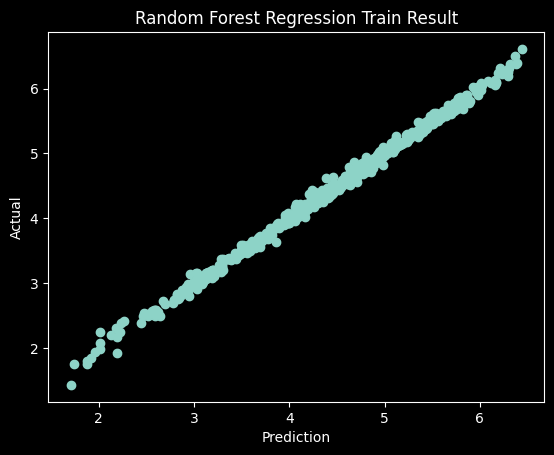

In [17]:
plt.scatter(np.array(rf_train_result.select('prediction').collect()),np.array(rf_train_result.select('scaledYield').collect()))
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Random Forest Regression Train Result')

Text(0.5, 1.0, 'Random Forest Regression Validation Result')

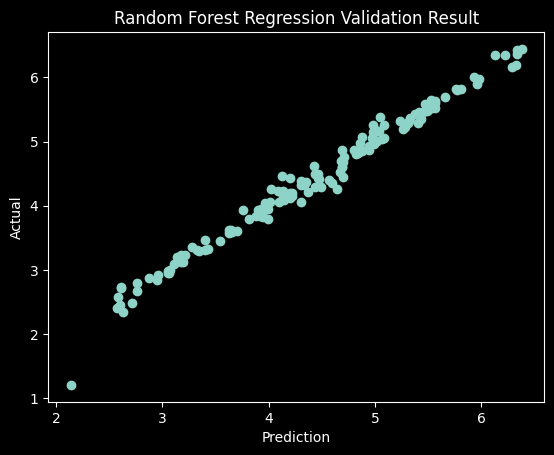

In [18]:
plt.scatter(np.array(rf_predictions.select('prediction').collect()),np.array(rf_predictions.select('scaledYield').collect()))
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Random Forest Regression Validation Result')